In [63]:
using Pkg
Pkg.add("Revise")
Pkg.add("Flux")
Pkg.add("DiffEqFlux")
Pkg.add("OrdinaryDiffEq")
Pkg.add("Plots")
Pkg.add("ProgressMeter")
Pkg.add("Printf")
Pkg.add("Kinetic")
Pkg.add("Optim")
Pkg.add("ProgressMeter")
Pkg.add("ProgressLogging")

  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Programming/Kinnosuke.jl/Project.toml`
 [no changes]
   Updating `~/Programming/Kinnosuke.jl/Manifest.toml`


In [64]:
using Revise, Flux, DiffEqFlux, OrdinaryDiffEq, ProgressMeter, Plots, Printf, Optim, Kinetic, ProgressMeter, ProgressLogging

In [67]:
#using Kinnosuke

#include("../src/Kinnosuke.jl")
#using .Kinnosuke

include("../src/train.jl")

LoadError: LoadError: ArgumentError: Unsupported optional arguments:
progress
`@withprogress` supports only following keyword arguments: name, parentid
in expression starting at /home/vavrines/Programming/Kinnosuke.jl/src/train.jl:40

In [4]:
cd(@__DIR__)
config = "config.txt"
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = homogeneous
maxTime = 5
tlen = 11
u0 = -5
u1 = 5
nu = 60
nug = 0
v0 = -5
v1 = 5
nv = 28
nvg = 0
w0 = -5
w1 = 5
nw = 28
nwg = 0
vMeshType = rectangle
nm = 5
knudsen = 1
inK = 0
alpha = 1.0
omega = 0.5
nh = 8



In [5]:
tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=tlen)

γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType)

f0 = Float32.(0.5 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .*
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
prim0 = conserve_prim(moments_conserve(f0, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
M0 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim0)) |> Array

mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0)
τ = mu_ref * 2. * prim0[end]^(0.5) / prim0[1];

phi, psi, phipsi = kernel_mode( nm, vSpace.u1, vSpace.v1, vSpace.w1, vSpace.du[1,1,1], vSpace.dv[1,1,1], vSpace.dw[1,1,1],
                                vSpace.nu, vSpace.nv, vSpace.nw, alpha );

function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

function bgk!(df, f::Array{<:Real,3}, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [6]:
# Boltzmann
prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz = solve(prob, Tsit5(), saveat=tRange) |> Array;

# BGK
prob1 = ODEProblem(bgk!, f0, tspan, [M0, τ])
data_bgk = solve(prob1, Tsit5(), saveat=tRange) |> Array;

data_boltz_1D = zeros(Float32, axes(data_boltz, 1), axes(data_boltz, 4))
data_bgk_1D = zeros(Float32, axes(data_bgk, 1), axes(data_bgk, 4))
for j in axes(data_boltz_1D, 2), i in axes(data_boltz_1D, 1)
    data_boltz_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_boltz[i,:,:,j])
    data_bgk_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_bgk[i,:,:,j])
end

f0_1D = zeros(Float32, axes(f0, 1))
for i in axes(data_boltz_1D, 1)
    f0_1D[i] = sum(@. vSpace.weights[i,:,:] * f0[i,:,:])
end

M0_1D = zeros(Float32, axes(M0, 1))
for i in axes(M0, 1)
    M0_1D[i] = sum(@. vSpace.weights[i,:,:] * M0[i,:,:])
end

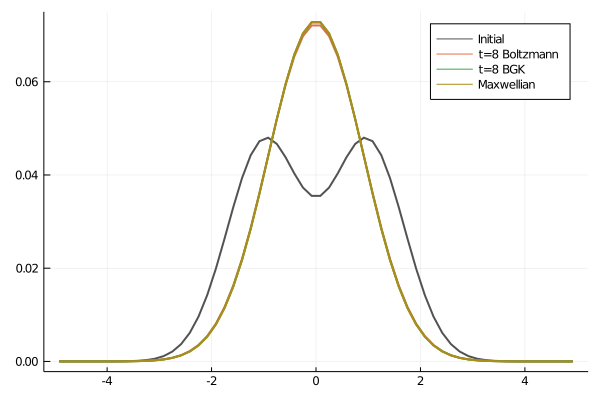

In [7]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32)
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,end], lw=2, label="t=8 Boltzmann")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,end], lw=2, label="t=8 BGK")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D[:], lw=2, label="Maxwellian", color=5)

In [56]:
#--- neural ode ---#
dudt = FastChain( (x, p) -> x.^2, # initial guess
                   FastDense(vSpace.nu, vSpace.nu*nh, tanh), # our 1-layer network
                   FastDense(vSpace.nu*nh, vSpace.nu) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

function loss_n_ode(p)
    pred = n_ode(f0_1D, p)
    loss = sum(abs2, pred .- data_boltz_1D)
    #loss = sum(abs2, pred .- (data_boltz_1D .- data_bgk_1D))
    return loss, pred
end

cb = function (p, l, pred; doplot=false)
    #display(l)
    # plot current prediction against dataset
    if doplot
        #pl = plot(tRange, data_boltz_1D[vSpace.nu÷2,:], lw=2, label="Exact")
        #scatter!(pl, tRange, pred[vSpace.nu÷2,:], lw=2, label="NN prediction")
        plt = contour(Array(tRange), vSpace.u[1:end,vSpace.nv÷2,vSpace.nw÷2], Array(pred), fill=false)
        display(plot(plt))
    end
    return false
end

#101 (generic function with 1 method)

In [66]:
res, anim = vis_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=20)

loss: 0.0639

ErrorException: `@logprogress` must be used inside `@withprogress` or with `_id` keyword argument